# improve_data_label_v14

v14: v13.3(pair-aware EGNN)을 **안전하게 로드/학습/재시작**할 수 있도록 안정성(로더/체크포인트)을 보강한 버전.

- 목표: v13 계열 성능 개선을 유지하면서 **"멈춤/로딩 실패"** 원인을 제거
- 입력: train_sequences.csv / validation_sequences.csv, train_labels.csv / validation_labels.csv


## v14 변경점 (v13.3에서 "로딩/진행이 안 되는" 이슈 해결)

1) **DataLoader 멈춤/무한대기/AssertionError 방지**
- 기본 `num_workers=0` (특히 Windows/Jupyter에서 안정)
- `timeout`은 **`num_workers>0`일 때만** 적용 (0일 때는 `timeout=0`으로 강제)

2) **셀 실행 순서 문제 제거**
- `train_loader` 생성 전에 호출되던 "first batch profile" 셀을 제거/통합

3) **체크포인트 저장/로딩(재시작) 추가**
- `state_dict` 기반 저장으로 클래스/경로 이슈 최소화
- shape가 맞는 파라미터만 부분 로드하는 **유연 로더(flexible load)** 제공


In [1]:

# ==========================================
# 0) Imports, Device, Config  [v14]
# ==========================================
import os, math, random
from dataclasses import dataclass
from typing import Optional, Any, Dict

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

@dataclass
class CFG:
    seed: int = 42

    # data
    max_len: int = 256
    min_valid: int = 10
    batch: int = 8
    num_workers: int = 0          # ✅ v14: 안전 기본값 (Windows/Jupyter에서 hang 방지)
    loader_timeout: int = 60      # ✅ num_workers>0 일 때만 사용

    # model
    vocab: int = 5  # PAD=0, A=1,C=2,G=3,U=4
    d_model: int = 192
    d_edge: int = 256
    n_layers: int = 8
    k_nn: int = 12  # sequence neighborhood edges
    num_preds: int = 4  # K heads
    dropout: float = 0.1

    # base-pair feature
    bp_tau: float = 40.0         # distance decay for |i-j|
    bp_min_sep: int = 4          # do not pair too-close residues
    pair_alpha: float = 2.0      # message/coord weight boost: (1 + pair_alpha * p_ij)

    # optimization
    lr: float = 2e-4
    weight_decay: float = 0.02
    epochs: int = 20
    warmup_epochs: int = 2
    grad_clip: float = 1.0

    # softmin aggregation
    softmin_temp: float = 1.0

    # losses
    use_confidence: bool = True
    conf_w: float = 0.05

    dist_w: float = 0.05         # weak distance auxiliary (as requested)
    pair_num_pairs: int = 512    # sampled pairs for distance/repulsion (speed-tuned)
    aux_every: int = 2           # compute expensive aux losses every N steps
    local_w: float = 0.2
    var_w: float = 0.02
    repulse_w: float = 0.02
    diversity_w: float = 0.01
    repulse_margin: float = 2.5
    diversity_margin: float = 2.0

    # checkpoint / resume
    ckpt_dir: str = "checkpoints"
    ckpt_best_path: str = "checkpoints/best_structured_v14.pt"
    ckpt_stage1_path: str = "checkpoints/best_stage1_v14.pt"
    resume_path: str = ""          # 예) "checkpoints/last.pt" 또는 v12/v13 state_dict 파일
    patience: int = 10

    # debug
    profile_first_batch: bool = True  # 첫 배치에서 to_gpu/forward 타이밍 출력

cfg = CFG()
os.makedirs(cfg.ckpt_dir, exist_ok=True)
seed_everything(cfg.seed)

# (선택) matmul 정밀도 힌트 (Ampere+에서 유효)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass


device: cuda


## 1) Dataset / Data Loading

In [2]:

# ==========================================
# 1) Load CSVs
# ==========================================
train_seq = pd.read_csv("train_sequences.csv")
val_seq   = pd.read_csv("validation_sequences.csv")

train_labels = pd.read_csv("train_labels.csv")
val_labels   = pd.read_csv("validation_labels.csv")

print("train_seq:", train_seq.shape, "val_seq:", val_seq.shape)
print("train_labels:", train_labels.shape, "val_labels:", val_labels.shape)

# ==========================================
# 2) Tokenize sequences (A,C,G,U -> 1..4, PAD=0)
# ==========================================
mapping = {'A': 1, 'C': 2, 'G': 3, 'U': 4}

def tokenize_sequence(seq: str):
    # unknown -> 0 (PAD)
    return [mapping.get(ch, 0) for ch in seq]

train_seq['tokens'] = train_seq['sequence'].astype(str).apply(tokenize_sequence)
val_seq['tokens']   = val_seq['sequence'].astype(str).apply(tokenize_sequence)

print(train_seq[['target_id','sequence']].head())
# ==========================================
# 3) Build coordinates + coord_mask from labels
# ==========================================
XYZ = ['x_1','y_1','z_1']
THRESH = 1e17

def _make_target_id_and_resid(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['target_id'] = df['ID'].astype(str).str.rsplit('_', n=1).str[0]
    df['resid'] = pd.to_numeric(df['resid'], errors='coerce')
    df = df.dropna(subset=['resid']).copy()
    df['resid'] = df['resid'].astype(int)
    df = df.sort_values(['target_id','resid'])
    return df

def build_coords_from_train_labels(train_labels: pd.DataFrame) -> pd.DataFrame:
    df = _make_target_id_and_resid(train_labels)
    for c in XYZ:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    arr = df[XYZ].to_numpy(dtype=np.float64)
    ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
    df['coord_ok'] = ok.astype(np.float32)
    df.loc[~ok, XYZ] = 0.0
    df[XYZ] = df[XYZ].astype(np.float32)

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

def build_coords_from_val_labels(val_labels: pd.DataFrame, K: int = 40) -> pd.DataFrame:
    df = _make_target_id_and_resid(val_labels)

    chosen = np.zeros((len(df), 3), dtype=np.float32)
    ok_mask = np.zeros((len(df),), dtype=np.float32)
    filled = np.zeros((len(df),), dtype=bool)

    for k in range(1, K+1):
        cols = [f'x_{k}', f'y_{k}', f'z_{k}']
        if not all(c in df.columns for c in cols):
            continue
        tmp = df[cols].apply(pd.to_numeric, errors='coerce')
        arr = tmp.to_numpy(dtype=np.float64)
        ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
        take = ok & (~filled)
        if take.any():
            chosen[take] = arr[take].astype(np.float32)
            ok_mask[take] = 1.0
            filled[take] = True

    df['x_1'] = chosen[:,0]
    df['y_1'] = chosen[:,1]
    df['z_1'] = chosen[:,2]
    df['coord_ok'] = ok_mask

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

train_coords = build_coords_from_train_labels(train_labels)
val_coords   = build_coords_from_val_labels(val_labels, K=40)

train_coords['target_id'] = train_coords['target_id'].astype(str).str.strip()
val_coords['target_id']   = val_coords['target_id'].astype(str).str.strip()

print("train_coords:", train_coords.shape)
print("val_coords  :", val_coords.shape)

def has_nan_inf(coords):
    a = np.asarray(coords, dtype=np.float32)
    return (not np.isfinite(a).all())

print("train_coords NaN/Inf:", train_coords['coordinates'].apply(has_nan_inf).sum())
print("val_coords   NaN/Inf:", val_coords['coordinates'].apply(has_nan_inf).sum())

C:\Users\tkdwl\AppData\Local\Temp\ipykernel_22132\799196925.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  train_labels = pd.read_csv("train_labels.csv")


train_seq: (5716, 8) val_seq: (28, 8)
train_labels: (7794971, 8) val_labels: (9762, 126)
  target_id                                           sequence
0      4TNA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
1      6TNA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
2      1TRA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
3      1TN2  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
4      1TN1  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
train_coords: (5716, 3)
val_coords  : (28, 3)
train_coords NaN/Inf: 0
val_coords   NaN/Inf: 0


In [3]:
# ==========================================
# 4) Build unified dataframe: sequences + coords
# ==========================================
all_seq = pd.concat([train_seq, val_seq], ignore_index=True)
all_coords = pd.concat([train_coords, val_coords], ignore_index=True)

all_seq['target_id'] = all_seq['target_id'].astype(str).str.strip()
all_coords['target_id'] = all_coords['target_id'].astype(str).str.strip()

all_df = all_seq.merge(all_coords, on='target_id', how='inner')

# keep only rows that have at least a few valid coordinates
def count_valid(m): 
    m = np.asarray(m, dtype=np.float32)
    return float(m.sum())

all_df['n_valid'] = all_df['coord_mask'].apply(count_valid)
all_df = all_df[all_df['n_valid'] >= cfg.min_valid].reset_index(drop=True)

print("all_df:", all_df.shape)
print(all_df[['target_id','n_valid']].head())


# ==========================================
# 5) Dataset (centering only; NO target-based RMS scaling)
# ==========================================
class RNADataset(Dataset):
    def __init__(self, tokens_list, coords_list, mask_list, max_len=256, center_only=True):
        self.tokens_list = tokens_list
        self.coords_list = coords_list
        self.mask_list = mask_list
        self.max_len = max_len
        self.center_only = center_only

    def __len__(self):
        return len(self.tokens_list)

    
    def __getitem__(self, idx):
        # 직접 참조 (복사 최소화)
        tokens = self.tokens_list[idx]
        coords = self.coords_list[idx]
        mask   = self.mask_list[idx]

        # numpy 변환 (필요 시 1회만)
        if not isinstance(tokens, np.ndarray):
            tokens = np.array(tokens, dtype=np.int64)
        if not isinstance(coords, np.ndarray):
            coords = np.array(coords, dtype=np.float32)
        if not isinstance(mask, np.ndarray):
            mask = np.array(mask, dtype=np.float32)

        L = min(len(tokens), len(coords), len(mask), self.max_len)

        tokens = tokens[:L]
        coords = coords[:L]
        mask   = mask[:L]

        if self.center_only:
            valid = mask.astype(bool)
            if valid.any():
                coords = coords - coords[valid].mean(axis=0, keepdims=True)

        # padding (vectorized, 최소 연산)
        tokens_p = np.zeros(self.max_len, dtype=np.int64)
        coords_p = np.zeros((self.max_len, 3), dtype=np.float32)
        mask_p   = np.zeros(self.max_len, dtype=np.float32)

        tokens_p[:L] = tokens
        coords_p[:L] = coords
        mask_p[:L]   = mask

        # torch.from_numpy (복사 없음 → 매우 빠름)
        return (
            torch.from_numpy(tokens_p),
            torch.from_numpy(coords_p),
            torch.from_numpy(mask_p),
        )

def filter_batch(tokens, target, mask, min_valid):
    # drop samples with too few valid coords (training stability)
    keep = (mask.sum(dim=1) >= min_valid)
    if keep.sum() < 2:
        return None
    return tokens[keep], target[keep], mask[keep]


# ==========================================
# 6) Train/Holdout split + DataLoader  [v13.2 speed]
# ==========================================
idx_train, idx_hold = train_test_split(range(len(all_df)), test_size=0.1, random_state=cfg.seed)

train_df = all_df.iloc[idx_train].reset_index(drop=True)
hold_df  = all_df.iloc[idx_hold].reset_index(drop=True)

train_ds = RNADataset(train_df['tokens'].tolist(),
                      train_df['coordinates'].tolist(),
                      train_df['coord_mask'].tolist(),
                      max_len=cfg.max_len,
                      center_only=True)

hold_ds  = RNADataset(hold_df['tokens'].tolist(),
                      hold_df['coordinates'].tolist(),
                      hold_df['coord_mask'].tolist(),
                      max_len=cfg.max_len,
                      center_only=True)

dl_num_workers = int(getattr(cfg, "num_workers", 0) or 0)

# NOTE (Windows/Jupyter): num_workers>0가 멈춘 것처럼 보이는 경우가 많습니다.
# v14 기본값은 0이며, 속도가 필요하면 2→4로 천천히 올려가며 확인하세요.
if os.name == "nt":
    dl_num_workers = 0

# ✅ 중요: PyTorch는 num_workers==0 인데 timeout>0이면 AssertionError가 날 수 있습니다.
timeout = int(getattr(cfg, "loader_timeout", 0) or 0) if (dl_num_workers > 0) else 0

dl_kwargs = dict(
    num_workers=dl_num_workers,
    pin_memory=(device.type == "cuda"),
)
if dl_num_workers > 0:
    dl_kwargs.update(dict(persistent_workers=True, prefetch_factor=2))

train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch,
    shuffle=True,
    timeout=timeout,
    **dl_kwargs
)
hold_loader = DataLoader(
    hold_ds,
    batch_size=cfg.batch,
    shuffle=False,
    timeout=timeout,
    **dl_kwargs
)

print("train batches:", len(train_loader), "hold batches:", len(hold_loader))

# ---- First-batch sanity check (detect loader hangs / preprocessing stalls) ----
import time as _time
_t0 = _time.time()
try:
    _it = iter(train_loader)
    _b = next(_it)
    print(f"[loader precheck] first batch OK in {_time.time()-_t0:.2f}s")
    # print shapes
    if isinstance(_b, (tuple, list)):
        print("[loader precheck] batch shapes:", [getattr(x, "shape", type(x)) for x in _b])
except Exception as e:
    print("[loader precheck] FAILED:", repr(e))
    raise




all_df: (5739, 12)
  target_id  n_valid
0      4TNA     76.0
1      6TNA     76.0
2      1TRA     76.0
3      1TN2     76.0
4      1TN1     76.0
train batches: 646 hold batches: 72
[loader precheck] first batch OK in 0.12s
[loader precheck] batch shapes: [torch.Size([8, 256]), torch.Size([8, 256, 3]), torch.Size([8, 256])]


## 2) Base-pair feature 주입

In [4]:

# ==========================================
# 2) Base-pair probability encoder (sequence-only heuristic)
#   - 입력 tokens(B,T) -> p(B,T,T) in [0,1]
#   - canonical: A-U, C-G, G-U wobble
#   - 거리 prior: exp(-|i-j|/tau), and |i-j|>=bp_min_sep
# ==========================================
class BasePairEncoder(nn.Module):
    def __init__(self, tau: float = 40.0, min_sep: int = 4):
        super().__init__()
        self.tau = float(tau)
        self.min_sep = int(min_sep)

        # 0 PAD, 1 A,2 C,3 G,4 U
        # canonical probs
        P = torch.zeros((5,5), dtype=torch.float32)
        P[1,4] = 1.0; P[4,1] = 1.0  # A-U
        P[2,3] = 1.0; P[3,2] = 1.0  # C-G
        P[3,4] = 0.6; P[4,3] = 0.6  # G-U wobble (weaker)
        self.register_buffer("pair_table", P, persistent=False)

    def forward(self, tokens: torch.Tensor, pad_mask: Optional[torch.Tensor] = None):
        """
        tokens: (B,T) int64
        pad_mask: (B,T) True for valid nodes (optional)
        returns p: (B,T,T) float32
        """
        B, T = tokens.shape
        t_i = tokens[:, :, None]  # (B,T,1)
        t_j = tokens[:, None, :]  # (B,1,T)

        base = self.pair_table[t_i, t_j]  # (B,T,T)

        # 거리 prior
        idx = torch.arange(T, device=tokens.device)
        dist = (idx[None, :, None] - idx[None, None, :]).abs().float()  # (1,T,T)
        sep_ok = (dist >= float(self.min_sep)).float()
        prior = torch.exp(-dist / max(self.tau, 1e-6)) * sep_ok

        p = base * prior  # (B,T,T)

        if pad_mask is not None:
            m = pad_mask.float()
            p = p * (m[:, :, None] * m[:, None, :])

        # zero diagonal
        p = p * (1.0 - torch.eye(T, device=p.device, dtype=p.dtype)[None, :, :])
        return p


## 3) Loss helpers (Kabsch + sampled distance + local/var)

In [5]:
def softmin_weights(losses: torch.Tensor, temperature: float = 1.0) -> torch.Tensor:
    """losses: (B,K) -> weights (B,K)"""
    return torch.softmax(-losses / max(float(temperature), 1e-8), dim=1)

def softmin_aggregate(losses: torch.Tensor, temperature: float = 1.0) -> torch.Tensor:
    """losses: (B,K) -> scalar"""
    w = softmin_weights(losses, temperature)
    return (w * losses).sum(dim=1).mean()

def masked_l1_losses(preds, target, mask) -> torch.Tensor:
    """Return per-head masked L1: (B,K)"""
    B, K, T, _ = preds.shape
    m = mask.unsqueeze(-1)  # (B,T,1)
    out = []
    denom = m.sum(dim=(1,2)).clamp_min(1.0)  # (B,)
    for k in range(K):
        pk = preds[:, k]
        diff = (pk - target).abs() * m
        l1 = diff.sum(dim=(1,2)) / denom
        out.append(l1)
    return torch.stack(out, dim=1)

def kabsch_align(P: torch.Tensor, Q: torch.Tensor, mask: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """Align P to Q using Kabsch. SVD always runs in FP32."""
    with torch.amp.autocast(device_type=('cuda' if P.is_cuda else 'cpu'), enabled=False):
        P32 = P.float()
        Q32 = Q.float()
        m32 = mask.float().unsqueeze(-1)  # (B,T,1)

        msum = m32.sum(dim=1, keepdim=True).clamp_min(eps)
        P_mean = (P32 * m32).sum(dim=1, keepdim=True) / msum
        Q_mean = (Q32 * m32).sum(dim=1, keepdim=True) / msum

        P_c = (P32 - P_mean) * m32
        Q_c = (Q32 - Q_mean) * m32

        H = torch.matmul(P_c.transpose(1, 2), Q_c).contiguous()  # (B,3,3)
        U, S, Vh = torch.linalg.svd(H, full_matrices=False)
        V = Vh.transpose(1, 2)

        det = torch.det(torch.matmul(V, U.transpose(1, 2)))
        sign = torch.where(det < 0, -torch.ones_like(det), torch.ones_like(det))

        E = torch.eye(3, device=H.device, dtype=H.dtype).unsqueeze(0).repeat(H.shape[0], 1, 1)
        E[:, 2, 2] = sign
        R = torch.matmul(torch.matmul(V, E), U.transpose(1, 2))  # (B,3,3)

        P_aligned = torch.matmul(P_c, R.transpose(1, 2)) + Q_mean
        P_aligned = P_aligned * m32

    return P_aligned.to(dtype=P.dtype)

def kabsch_rmsd_losses(preds, target, mask) -> torch.Tensor:
    """Per-head RMSD after Kabsch alignment: (B,K)"""
    B, K, T, _ = preds.shape
    out = []
    for k in range(K):
        pk = preds[:, k]
        pk_aligned = kabsch_align(pk, target, mask)
        diff_sq = (pk_aligned - target) ** 2
        sum_sq = (diff_sq * mask.unsqueeze(-1)).sum(dim=(1, 2))  # (B,)
        n_valid = (mask.sum(dim=1) * 3).clamp_min(1.0)
        rmsd = torch.sqrt(sum_sq / n_valid + 1e-8)  # (B,)
        out.append(rmsd)
    return torch.stack(out, dim=1)

def pairwise_distance_losses_sampled(preds, target, mask, num_pairs: int = 2048) -> torch.Tensor:
    """Per-head sampled pairwise distance MSE: (B,K)"""
    B, K, T, _ = preds.shape
    device_ = preds.device
    losses_bk = torch.zeros((B, K), device=device_, dtype=preds.dtype)

    valid_indices = [torch.where(mask[b].bool())[0] for b in range(B)]

    for b in range(B):
        idx = valid_indices[b]
        n = idx.numel()
        if n < 2:
            continue

        i = idx[torch.randint(0, n, (num_pairs,), device=device_)]
        j = idx[torch.randint(0, n, (num_pairs,), device=device_)]

        tgt_d = (target[b, i] - target[b, j]).norm(dim=-1)  # (num_pairs,)

        for k in range(K):
            pk = preds[b, k]
            pred_d = (pk[i] - pk[j]).norm(dim=-1)
            losses_bk[b, k] = ((pred_d - tgt_d) ** 2).mean()

    return losses_bk

def coord_variance_losses(preds: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Per-head masked coordinate variance (B,K). Larger is better (anti-collapse)."""
    B, K, T, _ = preds.shape
    m = mask.unsqueeze(-1)  # (B,T,1)
    denom = m.sum(dim=1, keepdim=True).clamp_min(1.0)  # (B,1,1)
    out = []
    for k in range(K):
        pk = preds[:, k]  # (B,T,3)
        mean = (pk * m).sum(dim=1, keepdim=True) / denom
        var = ((pk - mean) ** 2 * m).sum(dim=(1,2)) / denom.squeeze(1).squeeze(1).clamp_min(1.0)  # (B,)
        out.append(var)
    return torch.stack(out, dim=1)

def local_bond_losses(preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Per-head adjacent (i,i+1) bond length MSE: (B,K)."""
    B, K, T, _ = preds.shape
    m_adj = (mask[:, 1:] * mask[:, :-1]).bool()  # (B,T-1)
    tgt = (target[:, 1:] - target[:, :-1]).norm(dim=-1)  # (B,T-1)
    out = []
    denom = m_adj.sum(dim=1).clamp_min(1)  # (B,)
    for k in range(K):
        pk = preds[:, k]
        pd = (pk[:, 1:] - pk[:, :-1]).norm(dim=-1)
        diff = (pd - tgt) ** 2
        l = (diff * m_adj).sum(dim=1) / denom
        out.append(l)
    return torch.stack(out, dim=1)

def kabsch_rmsd_metric_min(preds, target, mask) -> torch.Tensor:
    with torch.no_grad():
        rmsd_bk = kabsch_rmsd_losses(preds, target, mask)  # (B,K)
        return rmsd_bk.min(dim=1).values.mean()

# ------------------------------------------
# TM-score metric (competition-aligned: best-of-K, index-matched residues)
# d0 follows the RNA Folding Kaggle metric (Ribonanza TM-score) piecewise form.
# ------------------------------------------
def _tm_d0(L: int) -> float:
    if L < 12: return 0.3
    if L < 15: return 0.4
    if L < 18: return 0.5
    if L < 21: return 0.6
    if L < 30: return 0.7
    return max(0.6 * math.sqrt(L - 0.5) - 2.5, 0.5)

def tm_score_single(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    pred_aligned = kabsch_align(pred, target, mask)
    d = (pred_aligned - target).norm(dim=-1)  # (B,T)
    m = mask.bool()
    tm_list = []
    for b in range(pred.shape[0]):
        idx = m[b]
        L = int(idx.sum().item())
        if L <= 0:
            tm_list.append(pred.new_tensor(0.0))
            continue
        d0 = _tm_d0(L)
        db = d[b, idx]
        tm = (1.0 / (1.0 + (db / d0) ** 2)).mean()
        tm_list.append(tm)
    return torch.stack(tm_list, dim=0)

def tm_score_metric_maxK(preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        B, K, T, _ = preds.shape
        tms = []
        for k in range(K):
            tm_k = tm_score_single(preds[:, k], target, mask)  # (B,)
            tms.append(tm_k)
        tms = torch.stack(tms, dim=1)  # (B,K)
        return tms.max(dim=1).values.mean()



In [6]:

# ==========================================
# v11 추가: non-neighbor repulsion + head diversity
# ==========================================
def repulsion_losses_sampled(preds: torch.Tensor, mask: torch.Tensor,
                             num_pairs: int = 2048, margin: float = 2.5) -> torch.Tensor:
    """겹침 방지용 hinge loss. 인접(i,i+1)은 제외하고 랜덤 pair에 대해
    d < margin 이면 (margin-d)^2 를 부과.
    returns (B,K)
    """
    B, K, T, _ = preds.shape
    device_ = preds.device
    losses = preds.new_zeros((B, K))
    valid_indices = [torch.where(mask[b].bool())[0] for b in range(B)]

    for b in range(B):
        idx = valid_indices[b]
        n = idx.numel()
        if n < 3:
            continue

        # sample pairs
        i = idx[torch.randint(0, n, (num_pairs,), device=device_)]
        j = idx[torch.randint(0, n, (num_pairs,), device=device_)]

        # exclude neighbors
        nn_mask = (torch.abs(i - j) > 1)
        if nn_mask.sum() < 8:
            continue
        i = i[nn_mask]
        j = j[nn_mask]

        for k in range(K):
            pk = preds[b, k]
            d = (pk[i] - pk[j]).norm(dim=-1)
            hinge = (margin - d).clamp_min(0.0)
            losses[b, k] = (hinge * hinge).mean()

    return losses

def head_diversity_losses(preds: torch.Tensor, mask: torch.Tensor, margin: float = 2.0) -> torch.Tensor:
    """헤드 간 유사하면 패널티. (B,K)로 반환해서 기존 softmin 프레임에 맞춘다.
    각 헤드의 masked centered coords를 만들고, 헤드쌍 RMSD가 margin보다 작으면 hinge.
    """
    B, K, T, _ = preds.shape
    m = mask.unsqueeze(-1)  # (B,T,1)
    denom = m.sum(dim=1, keepdim=True).clamp_min(1.0)
    # centered
    centered = preds - (preds * m.unsqueeze(1)).sum(dim=2, keepdim=True) / denom.unsqueeze(1)

    # pairwise head RMSD (no rotation; diversity 목적이라 단순 RMSD)
    out = preds.new_zeros((B, K))
    if K < 2:
        return out

    for a in range(K):
        pen = 0.0
        cnt = 0
        for b in range(K):
            if a == b: 
                continue
            diff = (centered[:, a] - centered[:, b])**2  # (B,T,3)
            rmsd = torch.sqrt((diff * m).sum(dim=(1,2)) / (mask.sum(dim=1).clamp_min(1.0)*3.0) + 1e-8)  # (B,)
            hinge = (margin - rmsd).clamp_min(0.0)
            pen = pen + hinge*hinge
            cnt += 1
        out[:, a] = pen / max(cnt, 1)
    return out


## 4) Model (Pair-aware EGNN)

In [7]:

# ==========================================
# 4) Model (EGNN backbone + Pair-aware message passing + K coord heads + ConfidenceHead)  [v13]
# ==========================================
class PositionalEncodingLearned(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2048):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)
        nn.init.normal_(self.pe.weight, mean=0.0, std=0.02)

    def forward(self, x):
        T = x.size(1)
        pos = torch.arange(T, device=x.device)
        return x + self.pe(pos)[None, :, :]

def build_seq_edges(T: int, k: int, device):
    r = max(1, k // 2)
    src = []
    dst = []
    for i in range(T):
        for j in range(max(0, i - r), min(T, i + r + 1)):
            if i == j:
                continue
            src.append(i); dst.append(j)
    edge_index = torch.tensor([src, dst], dtype=torch.long, device=device)  # (2,E)
    return edge_index

class EGNNPairAwareLayer(nn.Module):
    """
    EGNN + pair feature p_ij (base-pair 확률)
    message: phi(h_i, h_j, d_ij^2, p_ij)
    + long-range boost: (1 + pair_alpha * p_ij) 를 coord/node 업데이트에 곱한다.
    """
    def __init__(self, d_node: int, d_edge: int, dropout: float, pair_alpha: float = 2.0):
        super().__init__()
        self.pair_alpha = float(pair_alpha)

        self.edge_mlp = nn.Sequential(
            nn.Linear(d_node*2 + 1 + 1, d_edge),  # +p_ij
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(d_edge, d_edge),
            nn.SiLU(),
        )
        self.coord_mlp = nn.Sequential(
            nn.Linear(d_edge, d_edge),
            nn.SiLU(),
            nn.Linear(d_edge, 1),
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(d_node + d_edge, d_node),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(d_node, d_node),
        )
        self.ln = nn.LayerNorm(d_node)

    def forward(self, h, x, edge_index, node_mask, pair_p):
        """
        h: (B,T,D), x: (B,T,3)
        edge_index: (2,E)
        node_mask: (B,T) bool
        pair_p: (B,T,T) float in [0,1]
        """
        B, T, D = h.shape
        src, dst = edge_index[0], edge_index[1]  # (E,)

        hi = h[:, src, :]
        hj = h[:, dst, :]
        xi = x[:, src, :]
        xj = x[:, dst, :]

        rij = xi - xj
        dij2 = (rij * rij).sum(dim=-1, keepdim=True)  # (B,E,1)
        pij = pair_p[:, src, dst].unsqueeze(-1)        # (B,E,1)

        m_ij = self.edge_mlp(torch.cat([hi, hj, dij2, pij], dim=-1))  # (B,E,d_edge)
        boost = (1.0 + self.pair_alpha * pij).clamp(0.0, 10.0)

        w = self.coord_mlp(m_ij) * boost  # (B,E,1)
        dx = rij * w  # (B,E,3)

        agg_dx = x.new_zeros((B, T, 3))
        agg_m  = h.new_zeros((B, T, m_ij.size(-1)))

        agg_dx.index_add_(1, src, dx.to(agg_dx.dtype))
        agg_m.index_add_(1, src, (m_ij * boost).to(agg_m.dtype))

        if node_mask is not None:
            agg_dx = agg_dx.masked_fill(~node_mask[:, :, None], 0.0)
            agg_m  = agg_m.masked_fill(~node_mask[:, :, None], 0.0)

        x = x + agg_dx
        h = self.ln(h + self.node_mlp(torch.cat([h, agg_m], dim=-1)))

        if node_mask is not None:
            h = h.masked_fill(~node_mask[:, :, None], 0.0)
            x = x.masked_fill(~node_mask[:, :, None], 0.0)
        return h, x

class ConfidenceHead(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(cfg.d_model, cfg.d_model//2),
            nn.GELU(),
            nn.Dropout(cfg.dropout),
            nn.Linear(cfg.d_model//2, cfg.num_preds)
        )

    def forward(self, h, pad_mask):
        if pad_mask is None:
            pooled = h.mean(dim=1)
        else:
            m = pad_mask.float().unsqueeze(-1)
            denom = m.sum(dim=1).clamp_min(1.0)
            pooled = (h * m).sum(dim=1) / denom
        return self.mlp(pooled)  # (B,K)

class EGNNv13(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg
        self.embed = nn.Embedding(cfg.vocab, cfg.d_model, padding_idx=0)
        self.posenc = PositionalEncodingLearned(cfg.d_model, max_len=cfg.max_len)
        self.bp_enc = BasePairEncoder(tau=cfg.bp_tau, min_sep=cfg.bp_min_sep)

        self.layers = nn.ModuleList([
            EGNNPairAwareLayer(cfg.d_model, cfg.d_edge, cfg.dropout, pair_alpha=cfg.pair_alpha)
            for _ in range(cfg.n_layers)
        ])

        # K coord heads
        self.coord_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(cfg.d_model, cfg.d_model),
                nn.SiLU(),
                nn.Linear(cfg.d_model, 3),
            ) for _ in range(cfg.num_preds)
        ])
        self.conf_head = ConfidenceHead(cfg)

    def forward(self, tokens, pad_mask=None):
        """
        tokens: (B,T)
        pad_mask: (B,T) bool
        returns:
          preds: (B,K,T,3)
          conf_logits: (B,K)
        """
        B, T = tokens.shape
        if pad_mask is None:
            pad_mask = (tokens != 0)
        h = self.embed(tokens)
        h = self.posenc(h)
        if pad_mask is not None:
            h = h.masked_fill(~pad_mask[:, :, None], 0.0)

        # init coords at 0
        x = torch.zeros((B, T, 3), device=tokens.device, dtype=h.dtype)

        edge_index = build_seq_edges(T, self.cfg.k_nn, tokens.device)

        # pair probabilities (sequence-only heuristic)
        pair_p = self.bp_enc(tokens, pad_mask)  # (B,T,T)

        for layer in self.layers:
            h, x = layer(h, x, edge_index, pad_mask, pair_p)

        preds = []
        for head in self.coord_heads:
            preds.append(head(h).unsqueeze(1))
        preds = torch.cat(preds, dim=1)  # (B,K,T,3)

        conf_logits = self.conf_head(h, pad_mask)  # (B,K)
        return preds, conf_logits


## 5) LossComposer (weak distance auxiliary 포함)

In [8]:
# ==========================================
# 3) LossComposer  [v13.2]
#   - warmup: masked L1 (+optional confidence)
#   - main: Kabsch RMSD + (optional sampled pairwise/repulsion) + local + variance + diversity (+confidence)
#   - speed: compute expensive aux losses every cfg.aux_every steps
# ==========================================
class LossComposer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.kl = nn.KLDivLoss(reduction='batchmean')

    def forward(self, preds, target, mask, epoch, step: int = 0, conf_logits=None):
        temp = float(self.cfg.softmin_temp)

        # Stage 1: masked L1
        if epoch < self.cfg.warmup_epochs:
            l1_bk = masked_l1_losses(preds, target, mask)  # (B,K)
            loss = softmin_aggregate(l1_bk, temp)

            aux = 0.0
            if (conf_logits is not None) and self.cfg.use_confidence:
                with torch.no_grad():
                    w_t = softmin_weights(l1_bk, temp)
                logp = torch.log_softmax(conf_logits, dim=1)
                aux = self.kl(logp, w_t)
                loss = loss + float(self.cfg.conf_w) * aux

            return loss, "MASKED_L1(+CONF)" if aux != 0.0 else "MASKED_L1"

        # Stage 2: structured losses (all are (B,K))
        rmsd_bk = kabsch_rmsd_losses(preds, target, mask)
        loc_bk  = local_bond_losses(preds, target, mask)
        var_bk  = coord_variance_losses(preds, mask)

        # expensive aux losses: compute every N steps
        aux_every = int(getattr(self.cfg, "aux_every", 1))
        do_aux = (aux_every <= 1) or ((step % aux_every) == 0)

        if do_aux:
            num_pairs = int(self.cfg.pair_num_pairs)
            pair_bk = pairwise_distance_losses_sampled(preds, target, mask, num_pairs=num_pairs)
            rep_bk  = repulsion_losses_sampled(preds, mask, num_pairs=num_pairs,
                                               margin=float(self.cfg.repulse_margin))
        else:
            B, K = preds.shape[0], preds.shape[1]
            pair_bk = preds.new_zeros((B, K))
            rep_bk  = preds.new_zeros((B, K))

        # diversity is relatively cheap; keep every step
        div_bk  = head_diversity_losses(preds, mask, margin=float(self.cfg.diversity_margin))

        # weak auxiliary weights (as requested)
        dist_w_eff = float(self.cfg.dist_w)
        rep_w_eff  = float(self.cfg.repulse_w)

        total_bk = (
            rmsd_bk
            + dist_w_eff * pair_bk
            + float(self.cfg.local_w) * loc_bk
            - float(self.cfg.var_w) * var_bk
            + rep_w_eff * rep_bk
            + float(self.cfg.diversity_w) * div_bk
        )

        loss = softmin_aggregate(total_bk, temp)

        aux = 0.0
        if (conf_logits is not None) and self.cfg.use_confidence:
            with torch.no_grad():
                w_t = softmin_weights(total_bk, temp)
            logp = torch.log_softmax(conf_logits, dim=1)
            aux = self.kl(logp, w_t)
            loss = loss + float(self.cfg.conf_w) * aux

        return loss, "STRUCTURED(+CONF)" if aux != 0.0 else "STRUCTURED"


## 6) Training

In [9]:

# ==========================================
# 5.5) Checkpoint utils  [v14]
#   - state_dict 기반 저장/로드 (pickling 클래스 의존 X)
#   - flexible load: shape가 맞는 파라미터만 부분 로드
# ==========================================
from typing import Tuple, List, Optional, Any, Dict

def save_checkpoint(path: str,
                    model: nn.Module,
                    opt: Optional[torch.optim.Optimizer],
                    scaler: Optional[torch.amp.GradScaler],
                    epoch: int,
                    best_metric: Optional[float] = None,
                    cfg_obj: Optional[CFG] = None,
                    extra: Optional[Dict[str, Any]] = None):
    ckpt: Dict[str, Any] = {
        "epoch": int(epoch),
        "model": model.state_dict(),
        "best_metric": best_metric,
    }
    if opt is not None:
        ckpt["opt"] = opt.state_dict()
    if scaler is not None:
        try:
            ckpt["scaler"] = scaler.state_dict()
        except Exception:
            pass
    if cfg_obj is not None:
        ckpt["cfg"] = dict(cfg_obj.__dict__)
    if extra is not None:
        ckpt["extra"] = extra

    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    torch.save(ckpt, path)

def _unwrap_checkpoint(obj: Any) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    """Return (state_dict, meta_dict)."""
    if isinstance(obj, dict) and ("model" in obj) and isinstance(obj["model"], dict):
        return obj["model"], obj
    # v12/v13 일부는 model.state_dict()만 저장했을 수 있음
    if isinstance(obj, dict):
        return obj, {}
    raise TypeError(f"Unsupported checkpoint type: {type(obj)}")

def load_state_dict_flexible(model: nn.Module, state_dict: Dict[str, torch.Tensor], verbose: bool = True):
    model_sd = model.state_dict()
    loadable: Dict[str, torch.Tensor] = {}
    skipped: List[str] = []

    for k, v in state_dict.items():
        if (k in model_sd) and (tuple(model_sd[k].shape) == tuple(v.shape)):
            loadable[k] = v
        else:
            skipped.append(k)

    msg = model.load_state_dict(loadable, strict=False)

    if verbose:
        print(f"[flex load] loaded={len(loadable)}  skipped={len(skipped)}")
        # 너무 길어질 수 있으니 예시만
        if skipped:
            print("  - skipped examples:", skipped[:10])
        if hasattr(msg, "missing_keys") and msg.missing_keys:
            print("  - missing_keys examples:", msg.missing_keys[:10])
        if hasattr(msg, "unexpected_keys") and msg.unexpected_keys:
            print("  - unexpected_keys examples:", msg.unexpected_keys[:10])

    return msg, loadable, skipped

def load_checkpoint(path: str,
                    model: nn.Module,
                    opt: Optional[torch.optim.Optimizer] = None,
                    scaler: Optional[torch.amp.GradScaler] = None,
                    map_location: Any = "cpu",
                    flexible: bool = True,
                    verbose: bool = True):
    obj = torch.load(path, map_location=map_location)
    state_dict, meta = _unwrap_checkpoint(obj)

    if flexible:
        load_state_dict_flexible(model, state_dict, verbose=verbose)
    else:
        model.load_state_dict(state_dict, strict=True)

    if (opt is not None) and isinstance(meta, dict) and ("opt" in meta):
        try:
            opt.load_state_dict(meta["opt"])
        except Exception as e:
            print("[ckpt] opt load skipped:", repr(e))

    if (scaler is not None) and isinstance(meta, dict) and ("scaler" in meta):
        try:
            scaler.load_state_dict(meta["scaler"])
        except Exception as e:
            print("[ckpt] scaler load skipped:", repr(e))

    start_epoch = int(meta.get("epoch", -1)) + 1 if isinstance(meta, dict) else 0
    best_metric = meta.get("best_metric", None) if isinstance(meta, dict) else None
    return start_epoch, best_metric, meta


In [10]:

# ==========================================
# 6) Train loop + checkpoint/resume  [v14]
#   - num_workers/timeout 안전 처리(위 셀)
#   - stage1(best val loss), stage2(best TM-score) 저장
#   - resume_path 로 재시작 가능
# ==========================================
import time

model = EGNNv13(cfg).to(device)
loss_fn = LossComposer(cfg).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
use_amp = (device.type == "cuda")
scaler = torch.amp.GradScaler(device.type, enabled=use_amp)

# ----- (optional) resume -----
start_epoch = 0
best_stage1 = float("inf")
best_tm = -1e9
stale = 0
stage2_started = False

if isinstance(getattr(cfg, "resume_path", ""), str) and cfg.resume_path and os.path.exists(cfg.resume_path):
    print("[resume] loading:", cfg.resume_path)
    start_epoch, best_metric, meta = load_checkpoint(
        cfg.resume_path, model, opt=opt, scaler=scaler,
        map_location=device, flexible=True, verbose=True
    )
    # best_metric는 체크포인트에 저장된 값(있으면)
    if best_metric is not None:
        best_tm = float(best_metric)
    # extra에 stage1 loss를 저장했다면 복원
    if isinstance(meta, dict) and isinstance(meta.get("extra", None), dict):
        if "best_stage1" in meta["extra"]:
            best_stage1 = float(meta["extra"]["best_stage1"])
    print(f"[resume] start_epoch={start_epoch}  best_stage1={best_stage1:.6f}  best_tm={best_tm:.4f}")

def run_epoch(loader, epoch: int, train: bool):
    model.train(train)
    total_loss, n = 0.0, 0
    total_rmsd, n_r = 0.0, 0
    total_tm, n_t = 0.0, 0
    stage_name = None

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{cfg.epochs} [{'train' if train else 'eval'}]", mininterval=0.5)
    for step, (tokens, target, mask) in enumerate(pbar):
        do_prof = bool(getattr(cfg, "profile_first_batch", False)) and (epoch == start_epoch) and (step == 0)

        if do_prof:
            t0 = time.time()

        tokens = tokens.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        mask   = mask.to(device, non_blocking=True)

        if do_prof and device.type == "cuda":
            torch.cuda.synchronize()
            t1 = time.time()

        fb = filter_batch(tokens, target, mask, cfg.min_valid)
        if fb is None:
            continue
        tokens, target, mask = fb
        pad_mask = (tokens != 0)

        if train:
            opt.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            if do_prof:
                t2 = time.time()

            with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                preds, conf_logits = model(tokens, pad_mask)
                loss, stage_name = loss_fn(preds, target, mask, epoch, step=step, conf_logits=conf_logits)

            if do_prof and device.type == "cuda":
                torch.cuda.synchronize()
                t3 = time.time()
                print(f"[profile] step0 to_gpu: {t1-t0:.3f}s  forward+loss: {t3-t2:.3f}s")

            if train:
                scaler.scale(loss).backward()
                # grad clip (안정성)
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), float(cfg.grad_clip))
                scaler.step(opt)
                scaler.update()

        total_loss += float(loss.item()); n += 1

        if not train:
            rmsd = kabsch_rmsd_metric_min(preds, target, mask)
            tm   = tm_score_metric_maxK(preds, target, mask)
            total_rmsd += float(rmsd.item()); n_r += 1
            total_tm   += float(tm.item());   n_t += 1

        pbar.set_postfix(
            loss=total_loss/max(n,1),
            stage=stage_name,
            rmsd=(total_rmsd/max(n_r,1) if n_r>0 else None),
            tm=(total_tm/max(n_t,1) if n_t>0 else None),
        )

    avg_loss = total_loss/max(n,1)
    avg_rmsd = (total_rmsd/max(n_r,1) if n_r>0 else None)
    avg_tm   = (total_tm/max(n_t,1) if n_t>0 else None)
    return avg_loss, avg_rmsd, avg_tm, stage_name

last_path = os.path.join(cfg.ckpt_dir, "last_v14.pt")

for epoch in range(start_epoch, cfg.epochs):
    tr_loss, _, _, _ = run_epoch(train_loader, epoch, train=True)
    ev_loss, ev_rmsd, ev_tm, stage = run_epoch(hold_loader, epoch, train=False)
    print(f"[Epoch {epoch+1}] train_loss={tr_loss:.4f}  eval_loss={ev_loss:.4f}  eval_rmsd={ev_rmsd}  eval_tm={ev_tm}  stage={stage}")

    # --- always save last (resume용) ---
    save_checkpoint(
        last_path, model, opt, scaler, epoch,
        best_metric=best_tm,
        cfg_obj=cfg,
        extra={"best_stage1": best_stage1},
    )

    # --- Stage1: best val loss ---
    if epoch < cfg.warmup_epochs:
        if ev_loss < best_stage1 - 1e-4:
            best_stage1 = ev_loss
            save_checkpoint(cfg.ckpt_stage1_path, model, opt, scaler, epoch,
                            best_metric=best_stage1, cfg_obj=cfg)
            print(f"💾 stage1 best loss updated: {best_stage1:.6f} -> {cfg.ckpt_stage1_path}")
        continue

    # --- Stage2 starts: reset patience tracking once ---
    if not stage2_started:
        stage2_started = True
        best_tm = -1e9
        stale = 0
        print("🔁 Stage2 started: reset best_tm/stale")

    # --- Stage2: maximize TM-score (competition aligned) ---
    cur_tm = float(ev_tm) if ev_tm is not None else -1e9
    if cur_tm > best_tm + 1e-4:
        best_tm = cur_tm
        stale = 0
        save_checkpoint(cfg.ckpt_best_path, model, opt, scaler, epoch,
                        best_metric=best_tm, cfg_obj=cfg)
        print(f"✅ best TM updated: {best_tm:.4f} -> {cfg.ckpt_best_path}")
    else:
        stale += 1
        print(f"⏸ no TM improvement: {stale}/{cfg.patience}")
        if stale >= int(cfg.patience):
            print("🛑 early stopping (Stage2, TM-based).")
            break

# ---- load best for inference ----
if os.path.exists(cfg.ckpt_best_path):
    load_checkpoint(cfg.ckpt_best_path, model, opt=None, scaler=None, map_location=device, flexible=False, verbose=True)
    print("Best model loaded:", cfg.ckpt_best_path, "best_tm=", best_tm)
elif os.path.exists(cfg.ckpt_stage1_path):
    load_checkpoint(cfg.ckpt_stage1_path, model, opt=None, scaler=None, map_location=device, flexible=False, verbose=True)
    print("Stage1 best model loaded:", cfg.ckpt_stage1_path, "best_loss=", best_stage1)
else:
    print("No checkpoint found (best/stage1). Using current model in memory.")


Epoch 1/20 [train]:   0%|          | 0/646 [00:00<?, ?it/s, loss=43.3, rmsd=None, stage=MASKED_L1(+CONF), tm=None]

[profile] step0 to_gpu: 0.000s  forward+loss: 0.238s


Epoch 1/20 [eval]:   0%|          | 0/72 [00:00<?, ?it/s, loss=47.8, rmsd=19.3, stage=MASKED_L1(+CONF), tm=0.03]  

[profile] step0 to_gpu: 0.000s  forward+loss: 0.019s


Epoch 1/20 [eval]: 100%|██████████| 72/72 [00:03<00:00, 19.89it/s, loss=46.8, rmsd=19.3, stage=MASKED_L1(+CONF), tm=0.0285]


[Epoch 1] train_loss=46.9566  eval_loss=46.8489  eval_rmsd=19.28187674946255  eval_tm=0.028490615969834227  stage=MASKED_L1(+CONF)
💾 stage1 best loss updated: 46.848920 -> checkpoints/best_stage1_v14.pt


Epoch 2/20 [eval]: 100%|██████████| 72/72 [00:03<00:00, 20.68it/s, loss=46.6, rmsd=18.7, stage=MASKED_L1(+CONF), tm=0.0296]


[Epoch 2] train_loss=46.9628  eval_loss=46.6055  eval_rmsd=18.71289234691196  eval_tm=0.029642524068347283  stage=MASKED_L1(+CONF)
💾 stage1 best loss updated: 46.605546 -> checkpoints/best_stage1_v14.pt


Epoch 3/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 13.51it/s, loss=nan, rmsd=17.6, stage=STRUCTURED(+CONF), tm=0.0356]  


[Epoch 3] train_loss=61.2114  eval_loss=nan  eval_rmsd=17.61724699868096  eval_tm=0.03563034198143416  stage=STRUCTURED(+CONF)
🔁 Stage2 started: reset best_tm/stale
✅ best TM updated: 0.0356 -> checkpoints/best_structured_v14.pt


Epoch 4/20 [eval]: 100%|██████████| 72/72 [00:04<00:00, 18.00it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0363]  


[Epoch 4] train_loss=nan  eval_loss=nan  eval_rmsd=17.494313319524128  eval_tm=0.03625666259581016  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0363 -> checkpoints/best_structured_v14.pt


Epoch 5/20 [eval]: 100%|██████████| 72/72 [00:04<00:00, 16.57it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0363]  


[Epoch 5] train_loss=nan  eval_loss=nan  eval_rmsd=17.49255300892724  eval_tm=0.03628595204403003  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 1/10


Epoch 6/20 [eval]: 100%|██████████| 72/72 [00:04<00:00, 16.40it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0363]   


[Epoch 6] train_loss=nan  eval_loss=nan  eval_rmsd=17.491022811995613  eval_tm=0.03630802175030112  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 2/10


Epoch 7/20 [eval]: 100%|██████████| 72/72 [00:04<00:00, 17.91it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0363]   


[Epoch 7] train_loss=nan  eval_loss=nan  eval_rmsd=17.48945110374027  eval_tm=0.0363311962897165  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 3/10


Epoch 8/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 13.38it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0364]   


[Epoch 8] train_loss=nan  eval_loss=nan  eval_rmsd=17.487844440672134  eval_tm=0.03635546968628963  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 4/10


Epoch 9/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 13.45it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0364]  


[Epoch 9] train_loss=nan  eval_loss=nan  eval_rmsd=17.485793259408737  eval_tm=0.03636439760319061  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0364 -> checkpoints/best_structured_v14.pt


Epoch 10/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 13.27it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0364]  


[Epoch 10] train_loss=nan  eval_loss=nan  eval_rmsd=17.483467711342705  eval_tm=0.036399154742765755  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 1/10


Epoch 11/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 14.07it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0364]   


[Epoch 11] train_loss=nan  eval_loss=nan  eval_rmsd=17.480977018674213  eval_tm=0.03641002061259416  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 2/10


Epoch 12/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 13.46it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0364]   


[Epoch 12] train_loss=24.2422  eval_loss=nan  eval_rmsd=17.47854636775123  eval_tm=0.03637707893115779  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 3/10


Epoch 13/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 13.16it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0364]    


[Epoch 13] train_loss=nan  eval_loss=nan  eval_rmsd=17.476368731922573  eval_tm=0.036376104017512664  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 4/10


Epoch 14/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 13.17it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0364]   


[Epoch 14] train_loss=23.3967  eval_loss=nan  eval_rmsd=17.473519656393265  eval_tm=0.03637788938875827  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 5/10


Epoch 15/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 12.96it/s, loss=16.4, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0364]


[Epoch 15] train_loss=25.6825  eval_loss=16.4085  eval_rmsd=17.4703651799096  eval_tm=0.036359038980056844  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 6/10


Epoch 16/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 13.63it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0364] 


[Epoch 16] train_loss=23.8670  eval_loss=nan  eval_rmsd=17.467757410473293  eval_tm=0.0363524555383871  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 7/10


Epoch 17/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 13.21it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0363] 


[Epoch 17] train_loss=nan  eval_loss=nan  eval_rmsd=17.465536302990383  eval_tm=0.03633584206302961  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 8/10


Epoch 18/20 [eval]: 100%|██████████| 72/72 [00:04<00:00, 14.56it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0363] 


[Epoch 18] train_loss=nan  eval_loss=nan  eval_rmsd=17.463752786318462  eval_tm=0.03629639346359505  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 9/10


Epoch 19/20 [eval]: 100%|██████████| 72/72 [00:05<00:00, 14.05it/s, loss=nan, rmsd=17.5, stage=STRUCTURED(+CONF), tm=0.0362] 


[Epoch 19] train_loss=nan  eval_loss=nan  eval_rmsd=17.462135765287613  eval_tm=0.036238512153633766  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 10/10
🛑 early stopping (Stage2, TM-based).
Best model loaded: checkpoints/best_structured_v14.pt best_tm= 0.03636439760319061


## 7) Sanity check 시각화

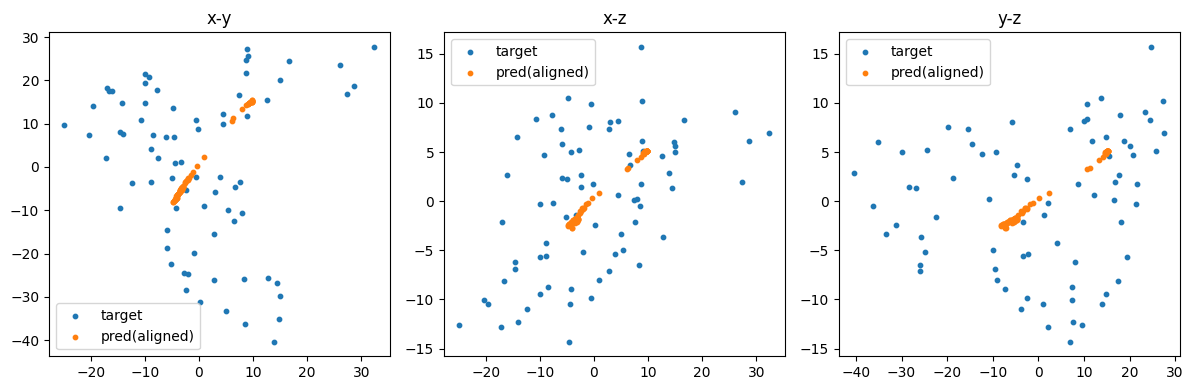

best head: 0 tm per head: [0.05299140885472298, 0.0015832831850275397, 0.03390466794371605, 0.02608020231127739]


In [11]:

# ==========================================
# 7) Quick sanity check plot (xy/xz/yz)
# ==========================================
import matplotlib.pyplot as plt

tokens, target, mask = next(iter(hold_loader))
tokens = tokens.to(device); target = target.to(device); mask = mask.to(device)
tokens, target, mask = filter_batch(tokens, target, mask, cfg.min_valid)
pad_mask = (tokens != 0)

model.eval()
with torch.no_grad():
    preds, conf_logits = model(tokens, pad_mask)  # (B,K,T,3)
    # pick best head by TM-score for sample 0
    tm_per_head = []
    for k in range(cfg.num_preds):
        tm = tm_score_single(preds[0:1, k], target[0:1], mask[0:1])
        tm_per_head.append(float(tm.item()))
    best_k = int(np.argmax(tm_per_head))
    pred0 = preds[0, best_k].detach()
    tgt0  = target[0].detach()
    m0    = mask[0].detach().bool()

    pred0a = kabsch_align(pred0.unsqueeze(0), tgt0.unsqueeze(0), mask[0:1]).squeeze(0)

def scat(a, b, title, ax):
    ax.scatter(a[:,0].cpu(), a[:,1].cpu(), s=10, label="target")
    ax.scatter(b[:,0].cpu(), b[:,1].cpu(), s=10, label="pred(aligned)")
    ax.set_title(title)
    ax.legend()

A = tgt0[m0]
B = pred0a[m0]

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].scatter(A[:,0].cpu(), A[:,1].cpu(), s=10, label="target")
axes[0].scatter(B[:,0].cpu(), B[:,1].cpu(), s=10, label="pred(aligned)")
axes[0].set_title("x-y"); axes[0].legend()

axes[1].scatter(A[:,0].cpu(), A[:,2].cpu(), s=10, label="target")
axes[1].scatter(B[:,0].cpu(), B[:,2].cpu(), s=10, label="pred(aligned)")
axes[1].set_title("x-z"); axes[1].legend()

axes[2].scatter(A[:,1].cpu(), A[:,2].cpu(), s=10, label="target")
axes[2].scatter(B[:,1].cpu(), B[:,2].cpu(), s=10, label="pred(aligned)")
axes[2].set_title("y-z"); axes[2].legend()

plt.tight_layout()
plt.show()

print("best head:", best_k, "tm per head:", tm_per_head)


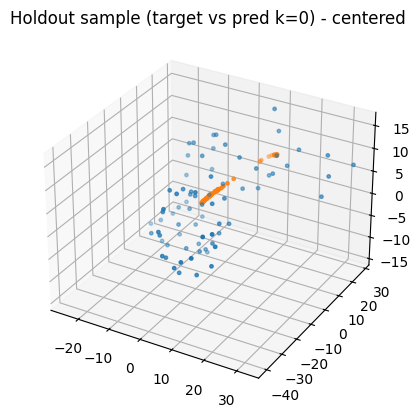

In [ ]:
import matplotlib.pyplot as plt

model.eval()
tokens_b, tgt_b, m_b = next(iter(hold_loader))
tokens_b = tokens_b.to(device)
tgt_b = tgt_b.to(device)
m_b = m_b.to(device)

with torch.no_grad():
    # 모델이 (coords, conf_logits) 튜플을 반환하므로 좌표만 받습니다.
    coords_b, _ = model(tokens_b)
pred0 = coords_b[0,0].detach().cpu().numpy()
tgt0  = tgt_b[0].detach().cpu().numpy()
m0    = m_b[0].detach().cpu().numpy().astype(bool)

pred0 = pred0[m0]
tgt0  = tgt0[m0]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(tgt0[:,0], tgt0[:,1], tgt0[:,2], s=6)
ax.scatter(pred0[:,0], pred0[:,1], pred0[:,2], s=6)
ax.set_title("Holdout sample (target vs pred k=0) - centered")
plt.show()